<a href="https://colab.research.google.com/github/goshACA/image-gender-classification/blob/main/GenderImageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Classification 
The main goal of the project is to teach the network to differentiate human gender based on face images.





### Downloading data

In [ ]:
!rm -rf data && mkdir data && wget http://info.iut-bm.univ-fcomte.fr/staff/couturie/img_align_celeba_small.zip  && unzip img_align_celeba_small.zip -d data/

In [2]:
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Rescaling
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


import matplotlib.pyplot as plt 
import os
import seaborn as sns
import shutil

In [ ]:
!pip install visualkeras # Used to visualize models

## Preprocessing Data 

The first step is to split data into train, validationa and test datasets. 
For that purpose, I'll use information that is already given in the **'Eval'** column **(1 - test, 0 - train)**. Because the values in the 'Male' column are the main interest, I'll drop it from the train (and validation) dataset.

In [10]:
df = pd.read_csv('data/img_align_celeba_small/list_attr_celeba_small.csv')

In [13]:
df.head()

image_id  Attractive  Heavy_Makeup  ...  Smiling  Young  Eval
0  000001.jpg           1             1  ...        1      1     0
1  000002.jpg           0             0  ...        1      1     0
2  000003.jpg           0             0  ...        0      1     0
3  000004.jpg           1             0  ...        0      1     0
4  000005.jpg           1             1  ...        0      1     0

[5 rows x 8 columns]

In [11]:
df.replace(to_replace=-1, value=0, inplace=True)
df_train = df[df['Eval'] == 0].drop(['Eval'], axis=1)
df_train, df_valid = np.split(df_train.sample(frac=1, random_state=42), [int(0.85 * len(df_train))])
x_train = df_train.drop(['Male'], axis = 1)
y_train = df_train['Male']
x_valid = df_valid.drop(['Male'], axis = 1)
y_valid = df_valid['Male']
df_test = df[df['Eval'] == 1].drop(['Eval'], axis=1)
x_test = df_test.drop(['Male'], axis = 1)
y_test = df_test['Male']

class_names = ['male', 'female']

In [12]:
print("X_train's shape: ", x_train.shape)
print("Y_train's shape: ", y_train.shape)
print("X_valid's shape: ", x_valid.shape)
print("Y_valid's shape: ", y_valid.shape)
print("X_test's shape: ", x_test.shape)
print("Y_test's shape: ", y_test.shape)

print(x_train.columns)
x_test.head()


X_train's shape:  (42499, 6)
Y_train's shape:  (42499,)
X_valid's shape:  (7500, 6)
Y_valid's shape:  (7500,)
X_test's shape:  (10001, 6)
Y_test's shape:  (10001,)
Index(['image_id', 'Attractive', 'Heavy_Makeup', 'Pointy_Nose', 'Smiling',
       'Young'],
      dtype='object')


image_id  Attractive  Heavy_Makeup  Pointy_Nose  Smiling  Young
49999  050000.jpg           1             1            1        0      1
50000  050001.jpg           1             1            0        1      1
50001  050002.jpg           0             0            0        0      1
50002  050003.jpg           0             0            1        1      0
50003  050004.jpg           0             0            1        1      1

In [14]:
img_folder = 'data/img_align_celeba_small/img_align_celeba_small/'
x_train.describe()

Attractive  Heavy_Makeup   Pointy_Nose       Smiling         Young
count  42499.000000  42499.000000  42499.000000  42499.000000  42499.000000
mean       0.515518      0.384927      0.275724      0.477423      0.782442
std        0.499765      0.486584      0.446884      0.499496      0.412590
min        0.000000      0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000      1.000000
50%        1.000000      0.000000      0.000000      0.000000      1.000000
75%        1.000000      1.000000      1.000000      1.000000      1.000000
max        1.000000      1.000000      1.000000      1.000000      1.000000

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


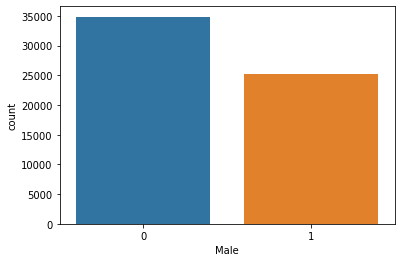

In [15]:
sns.countplot(df["Male"])
plt.show() 

## Plotting images

In [16]:
def plot_img(img_id):
  example_pic = img_folder + img_id
  img = load_img(example_pic)
  print(img.size)
  plt.grid(False)
  plt.imshow(img)


def plot_img_grid(df=x_test, img_path=img_folder, y_pred=y_test):
  f, axs = plt.subplots(3,3, figsize=(8, 10))
  axs = axs.flatten()
  imgs = df['image_id'][0:9].to_list()
  for img, ax in zip(imgs, axs):
    ax.set_axis_off()
    ax.set_title(class_names[1 - y_pred.iloc[imgs.index(img)]])
    ax.imshow(load_img(img_path+img))
  
def plot_datagen(datagen, model=None, isTest=False):
  f, axs = plt.subplots(3,3, figsize=(8, 10))
  axs = axs.flatten()
  for i in range(9):
    if isTest:
      img = datagen.next()
    else:
      img, label = datagen.next()
    if model is not None:
        pred = model.predict(img)
        y_pred = pred.argmax(axis=-1)
        axs[i].set_title(class_names[1 - y_pred[0]])
    axs[i].imshow(img[0])


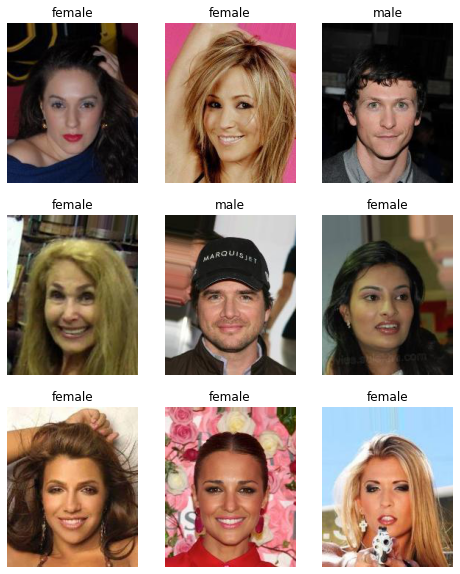

In [17]:
plot_img_grid()

(178, 218)


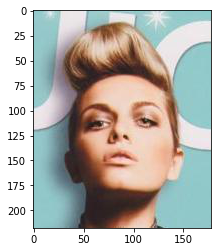

In [18]:
plot_img('000005.jpg')

## Split data into folders
*Folder structure:*<br>
── **data** <br>
||  ├── **train**  - (42499)<br>
||  │   ├── male <br>
||  │   └── female         
||  ├── **valid**  - (7500)<br>
||  │   ├── male <br>
||  │   └── female                       
||  ├── **test**   - (10001)            
||  │   ├── male <br>
||  │   └── female                        
                  





In [19]:
path_to_files="data/img_align_celeba_small/img_align_celeba_small/"
path_to_men_train = "data/train/male"
path_to_women_train = "data/train/female"
path_to_men_valid = "data/valid/male"
path_to_women_valid = "data/valid/female"
path_to_men_test = "data/test/male"
path_to_women_test = "data/test/female"
path_to_train = 'data/train'
path_to_test = "data/test"
path_to_valid = "data/valid"

In [20]:
!mkdir 'data/train'
!mkdir 'data/train/male'
!mkdir "data/train/female"
!mkdir  "data/valid"
!mkdir "data/valid/male"
!mkdir "data/valid/female"
!mkdir "data/test"
!mkdir "data/test/male"
!mkdir "data/test/female"

In [21]:
def copy_files_to_folder(df, path_to_files, path_to_folders):
  for curr_file in df[df['Male'] == 1]['image_id']:
    shutil.copyfile(os.path.join(path_to_files, curr_file),
                    os.path.join(path_to_folders[0], curr_file)) 
  for curr_file in df[df['Male'] == 0]['image_id']:
    shutil.copyfile(os.path.join(path_to_files, curr_file),
                    os.path.join(path_to_folders[1], curr_file)) 

In [22]:
copy_files_to_folder(df_train, path_to_files, [path_to_men_train, path_to_women_train])
copy_files_to_folder(df_valid, path_to_files, [path_to_men_valid, path_to_women_valid])
copy_files_to_folder(df_test, path_to_files, [path_to_men_test, path_to_women_test])

In [23]:
!ls "data/test/" 
!ls "data/test/male" | wc -l
!ls "data/test/female" | wc -l

female	male
4200
5801


## Data Augmentation

In [24]:
img_h = 218
img_w = 178
img_shape = (img_w, img_h)
batch_size = 32
num_classes = 2
epochs = 15
steps_per_epoch = 500

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_directory(
    path_to_train, 
    target_size=(img_w, img_h),
    class_mode='categorical',
    color_mode="rgb",
    batch_size=batch_size,
    subset='training',
    shuffle=True,
    seed=42
)


valid_generator = train_datagen.flow_from_directory(
    path_to_valid,
    target_size=img_shape,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset='training',
    shuffle=True,
    seed=42)



Found 42499 images belonging to 2 classes.
Found 7500 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1 / 255.0)
test_generator = test_datagen.flow_from_directory(
    path_to_test,
    target_size=(img_w, img_h),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 10001 images belonging to 2 classes.


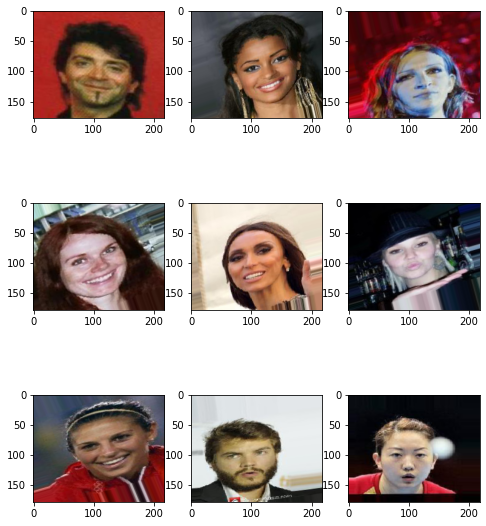

In [ ]:
plot_datagen(train_generator)

## Training features and utils

Let's create a dataframe to save model specific information, thus it will allow to easily compare the results.

In [26]:
df_res = pd.DataFrame(columns=['name', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc', 'accuracy'])

### Registering callbacks 
To imrove the learning on the train dataset, we can define callbacks such as **EarlyStopping** with patience at 10 epochs, **ReduceLROnPlateau**.
* The first one stops the learning process if no improvement of learning rate was registered. 
* The second one is used to reduce learning rate when a metric has stopped improving.  

In [27]:
def def_weight_path(model_name):
  return model_name + '_weights.h5'

In [28]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


callbacks = [earlystop, learning_rate_reduction]


### Training util functions

In [ ]:
import visualkeras

def visualize_model(model, scale=3):
  return visualkeras.layered_view(model, scale_xy=scale, max_z=1000)

In [ ]:
def plot_history_res(history, arg_list, label_list, title):
  plt.figure(figsize=(18,4))
  for i in range(len(arg_list)):
    plt.plot(history[arg_list[i]], label=label_list[i])
  plt.legend()
  plt.title(title)
  plt.show()

In [ ]:
def convert_str_to_ind(name):
  return int(name.split('/')[1].split('.')[0])

def calculate_accuracy(model, model_name):
  scores = model.predict(test_generator, 400, workers = 10)
  correct = 0
  for i, n in enumerate(test_generator.filenames):
    if y_test[convert_str_to_ind(n)-1] == 0 and scores[i][0] > 0.5:
      correct += 1
    if y_test[convert_str_to_ind(n)-1] == 1 and scores[i][0] <= 0.5:
      correct += 1

  print("Correct:", correct, " Total: ", len(test_generator.filenames))
  accuracy = correct / len(test_generator.filenames)
  df_res.loc[(df_res.name==model_name), 'accuracy'] = accuracy
  print("Accuracy: ", accuracy)
  plot_datagen(test_generator, model, isTest=True)
  plot_datagen(valid_generator, model)
  return accuracy

*Let's define a core function to train a model.* 

The main functionalities are:
* try to load the weights and history supposing they are already saved (the model was already trained) to save running time.
* if the model wasn't already trained (caught an error rased because of the absence of files with model features), train it and save the weights and history to specifically named files.
* for both cases at the end we get trained model and history, thus the results can be plotted and saved to the df_res dataset along with the calculated test accuracy.

In [29]:
def train_test_model(model, model_name, df_res = df_res):
  weight_path = def_weight_path(model_name)
  try:
    model.load_weights(weight_path)
    history = np.load(model_name + '_history.npy',allow_pickle='TRUE').item()
  except OSError:
    history = model.fit(train_generator, validation_data = valid_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, callbacks=callbacks)
    history = history.history
    np.save(model_name+'_history.npy', history)
    model.save_weights(weight_path)
  #plotting results
  plot_history_res(history, ['loss', 'val_loss'], ['train', 'validation'], 'Loss Function Comparison')
  plot_history_res(history, ['accuracy', 'val_accuracy'], ['train', 'validation'], 'Accuracy Comparison') 
  accuracy = calculate_accuracy(model, model_name)
  #saving results
  df_res.loc[len(df_res)] = [model_name, history['loss'],history['accuracy'],  history['val_loss'],  history['val_accuracy'], accuracy]
  return df_res

# Training models

Let's start the training part using newly defined, predefined and pretrained models.

## Training simple model

The first model to train is a simple model, newly defined, containing consecutive blocks of Conv2D, BatchNormalization, MaxPooling2D and Dropout layers in the sizes 32, 64, 128.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential(name='simple_model')

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_w, img_h, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 176, 216, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 176, 216, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 108, 32)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 88, 108, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 86, 106, 64)       18496     
                                                                 
 batch_normalization_1 (Batc  (None, 86, 106, 64)     

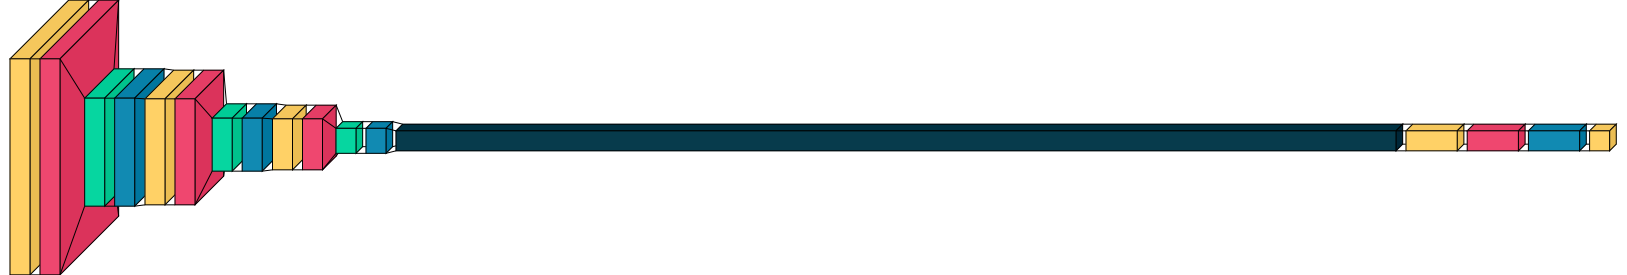

In [ ]:
visualize_model(model, scale=1)

Epoch 1/15
500/500 [==============================] - 202s 370ms/step - loss: 0.6688 - accuracy: 0.7301 - val_loss: 0.5254 - val_accuracy: 0.7461 - lr: 0.0010
Epoch 2/15
500/500 [==============================] - 188s 375ms/step - loss: 0.4073 - accuracy: 0.8194 - val_loss: 0.4054 - val_accuracy: 0.8244 - lr: 0.0010
Epoch 3/15
500/500 [==============================] - 186s 372ms/step - loss: 0.3363 - accuracy: 0.8556 - val_loss: 0.3312 - val_accuracy: 0.8528 - lr: 0.0010
Epoch 4/15
500/500 [==============================] - 183s 366ms/step - loss: 0.2916 - accuracy: 0.8775 - val_loss: 0.2361 - val_accuracy: 0.9049 - lr: 0.0010
Epoch 5/15
500/500 [==============================] - 182s 364ms/step - loss: 0.2484 - accuracy: 0.8992 - val_loss: 0.2259 - val_accuracy: 0.9104 - lr: 0.0010
Epoch 6/15
500/500 [==============================] - 181s 363ms/step - loss: 0.2379 - accuracy: 0.9014 - val_loss: 0.4238 - val_accuracy: 0.8493 - lr: 0.0010
Epoch 7/15
500/500 [==========================

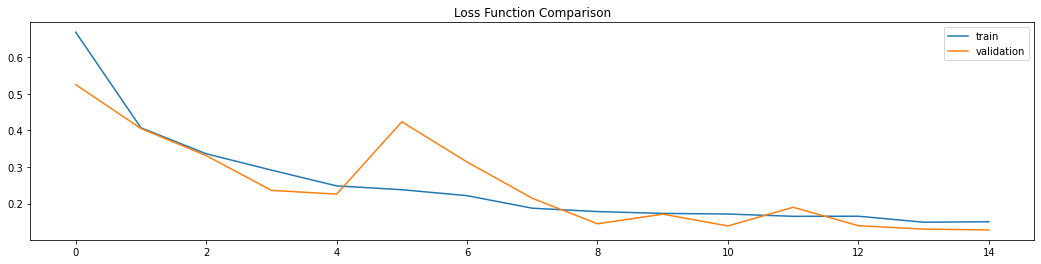

[0.7300624847412109, 0.819360077381134, 0.8556249737739563, 0.8774654269218445, 0.8991875052452087, 0.9013749957084656, 0.9083964824676514, 0.9243124723434448, 0.9279999732971191, 0.9313750267028809, 0.9331874847412109, 0.9357500076293945, 0.9333750009536743, 0.942312479019165, 0.9412059187889099]
[0.7461333274841309, 0.824400007724762, 0.8528000116348267, 0.9049333333969116, 0.9103999733924866, 0.8493333458900452, 0.8565333485603333, 0.9139999747276306, 0.9438666701316833, 0.9362666606903076, 0.9472000002861023, 0.9317333102226257, 0.9457333087921143, 0.9516000151634216, 0.9490666389465332]


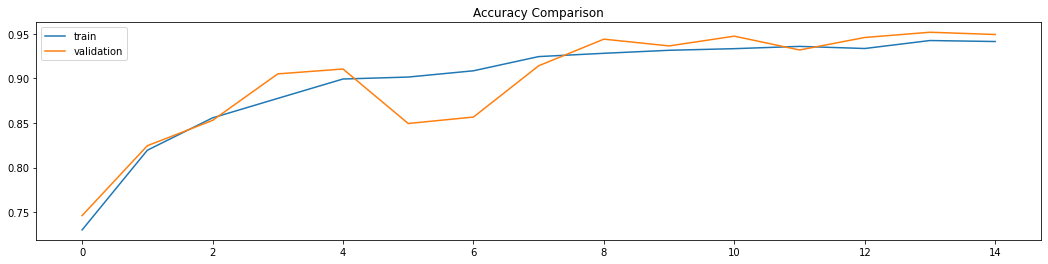

Correct: 9606  Total:  10001
Accuracy:  0.9605039496050395


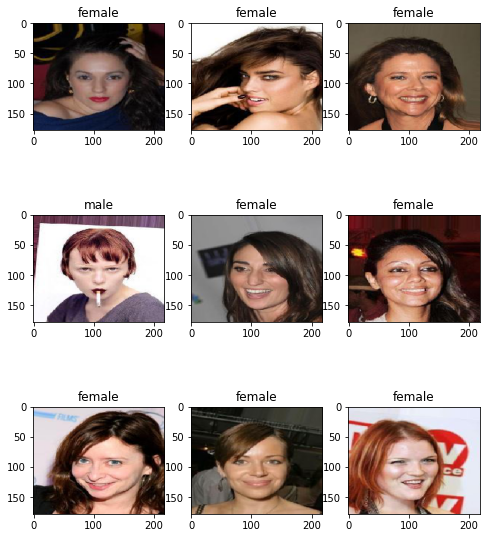

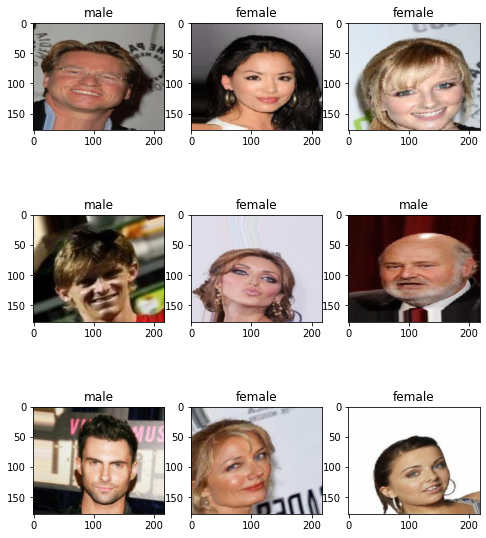

In [ ]:
df_res = train_test_model(model, 'simple_model')

## Defining and training scalable models


Let's try to make the model definition more scalable. Thus, the function below defines a model with variable number of consecutive blocks of Conv2D, Maxpooling2D and Dropout(not necessarily) layers with custom sizes, using given activation function and optimizer.

In [ ]:
def define_model(shape, model_name, kernel_size=3, conv_layer_count=3, pool_size=2, layers_size=[32, 64, 128], dropout=True, dropout_size=0.3, activation="sigmoid", optimizer=RMSprop(learning_rate=0.0001), loss='binary_crossentropy'):
  model = Sequential(name=model_name)
  model.add(Conv2D(layers_size[0], kernel_size, activation = 'relu', input_shape = (img_w, img_h, 3) , padding='same'))

  for j in layers_size:
    for i in range(conv_layer_count):
      model.add(Conv2D(j, kernel_size, activation = 'relu', padding='same'))
    model.add(MaxPooling2D(pool_size = pool_size, padding='same')) 
    if dropout:
      model.add(Dropout(dropout_size))

  model.add(Flatten())
  model.add(Dense(256, activation = "relu"))
  model.add(Dropout(dropout_size))
  model.add(Dense(2, activation = activation))

  model.summary()
  model.compile(optimizer, loss=loss, 
              metrics=['accuracy'])
  return model

Let's try a model with 3 consecutive blocks and increased layer sizes.

Model: "simple_model_layer_3_inc"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_121 (Conv2D)         (None, 178, 218, 48)      1344      
                                                                 
 conv2d_122 (Conv2D)         (None, 178, 218, 48)      20784     
                                                                 
 conv2d_123 (Conv2D)         (None, 178, 218, 48)      20784     
                                                                 
 conv2d_124 (Conv2D)         (None, 178, 218, 48)      20784     
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 89, 109, 48)      0         
 g2D)                                                            
                                                                 
 dropout_46 (Dropout)        (None, 89, 109, 48)       0         
                                          

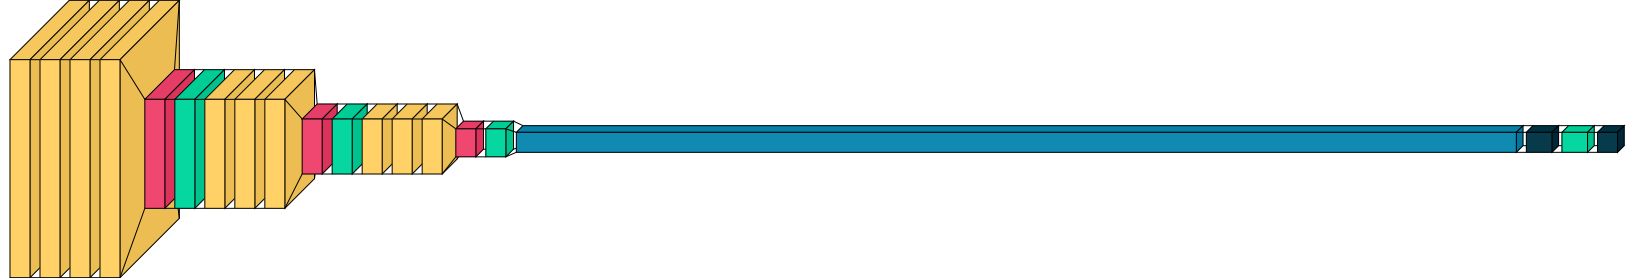

In [ ]:
model = define_model(img_shape, 'simple_model_layer_3_inc', conv_layer_count=3, layers_size=[48, 96, 192])
visualize_model(model, scale=1)

Epoch 1/15
500/500 [==============================] - 190s 375ms/step - loss: 0.5689 - accuracy: 0.7093 - val_loss: 0.5328 - val_accuracy: 0.7424 - lr: 1.0000e-04
Epoch 2/15
500/500 [==============================] - 188s 376ms/step - loss: 0.4681 - accuracy: 0.7857 - val_loss: 0.4162 - val_accuracy: 0.8356 - lr: 1.0000e-04
Epoch 3/15
500/500 [==============================] - 187s 375ms/step - loss: 0.3711 - accuracy: 0.8407 - val_loss: 0.2880 - val_accuracy: 0.8805 - lr: 1.0000e-04
Epoch 4/15
500/500 [==============================] - 188s 376ms/step - loss: 0.2777 - accuracy: 0.8864 - val_loss: 0.2312 - val_accuracy: 0.9049 - lr: 1.0000e-04
Epoch 5/15
500/500 [==============================] - 188s 376ms/step - loss: 0.2423 - accuracy: 0.9043 - val_loss: 0.2090 - val_accuracy: 0.9152 - lr: 1.0000e-04
Epoch 6/15
500/500 [==============================] - 187s 373ms/step - loss: 0.2211 - accuracy: 0.9104 - val_loss: 0.1909 - val_accuracy: 0.9256 - lr: 1.0000e-04
Epoch 7/15
500/500 [==

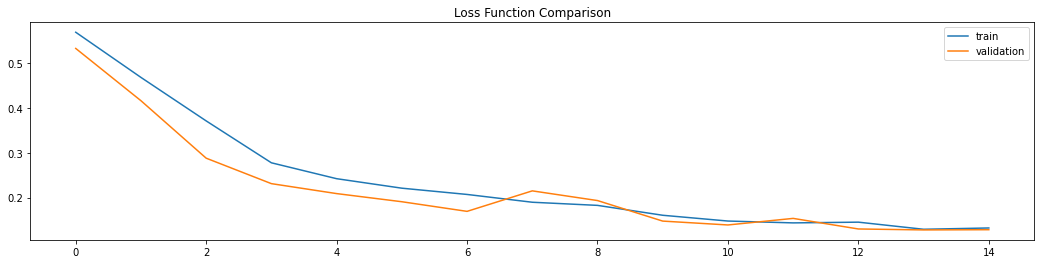

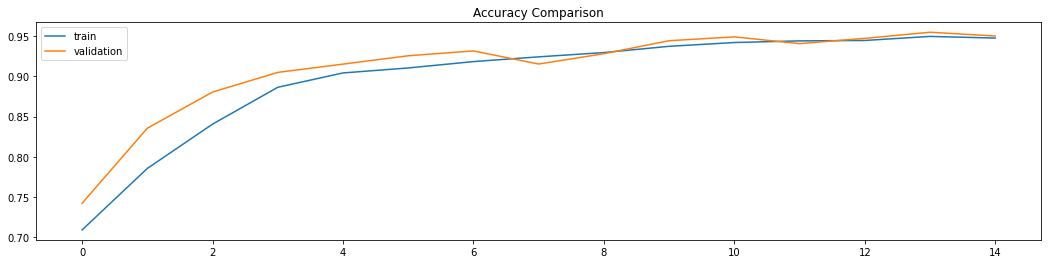

Correct: 9618  Total:  10001
Accuracy:  0.9617038296170383
                       name  ...  accuracy
0              simple_model  ...  0.960504
1      simple_model_layer_5  ...  0.950305
2  simple_model_layer_3_inc  ...  0.961704

[3 rows x 6 columns]


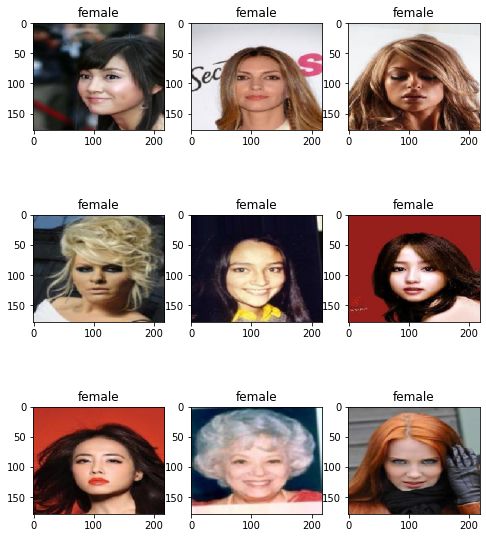

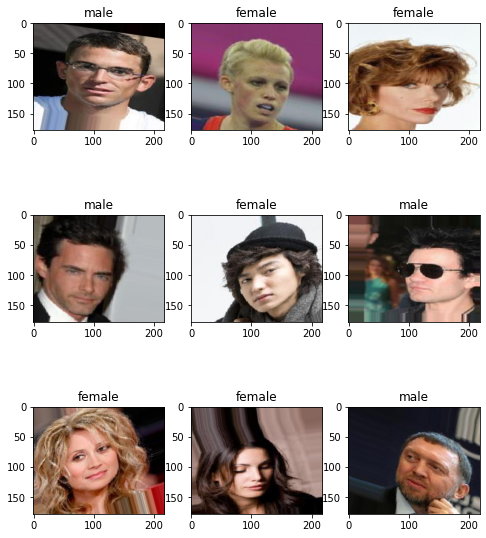

In [ ]:
df_res = train_test_model(model, 'simple_model_layer_3_inc')

Getting the test accuracy = 0.961704, let's try to change the activation and optimizer.

Model: "simple_model_layer_3_inc_soft_adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_131 (Conv2D)         (None, 178, 218, 48)      1344      
                                                                 
 conv2d_132 (Conv2D)         (None, 178, 218, 48)      20784     
                                                                 
 conv2d_133 (Conv2D)         (None, 178, 218, 48)      20784     
                                                                 
 conv2d_134 (Conv2D)         (None, 178, 218, 48)      20784     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 89, 109, 48)      0         
 g2D)                                                            
                                                                 
 dropout_50 (Dropout)        (None, 89, 109, 48)       0         
                                

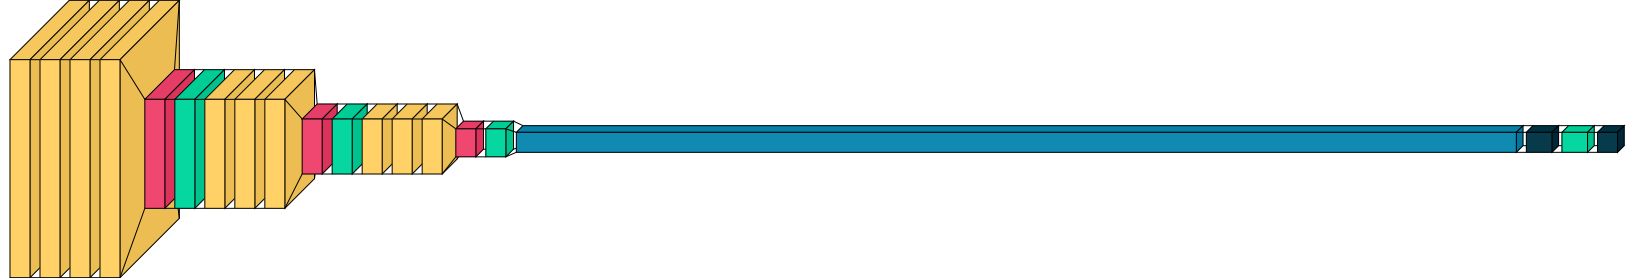

In [ ]:
model = define_model(img_shape, 'simple_model_layer_3_inc_soft_adam', conv_layer_count=3, layers_size=[48, 96, 192] , activation='softmax', optimizer=Adam(learning_rate=0.0001))
visualize_model(model, scale=1)

Epoch 1/15
500/500 [==============================] - 188s 374ms/step - loss: 0.5686 - accuracy: 0.7016 - val_loss: 0.4822 - val_accuracy: 0.7695 - lr: 1.0000e-04
Epoch 2/15
500/500 [==============================] - 187s 373ms/step - loss: 0.4334 - accuracy: 0.7976 - val_loss: 0.3561 - val_accuracy: 0.8484 - lr: 1.0000e-04
Epoch 3/15
500/500 [==============================] - 187s 374ms/step - loss: 0.2885 - accuracy: 0.8783 - val_loss: 0.2334 - val_accuracy: 0.9043 - lr: 1.0000e-04
Epoch 4/15
500/500 [==============================] - 188s 376ms/step - loss: 0.2331 - accuracy: 0.9020 - val_loss: 0.2061 - val_accuracy: 0.9159 - lr: 1.0000e-04
Epoch 5/15
500/500 [==============================] - 188s 375ms/step - loss: 0.2023 - accuracy: 0.9189 - val_loss: 0.1714 - val_accuracy: 0.9319 - lr: 1.0000e-04
Epoch 6/15
500/500 [==============================] - 187s 374ms/step - loss: 0.1828 - accuracy: 0.9274 - val_loss: 0.1649 - val_accuracy: 0.9303 - lr: 1.0000e-04
Epoch 7/15
500/500 [==

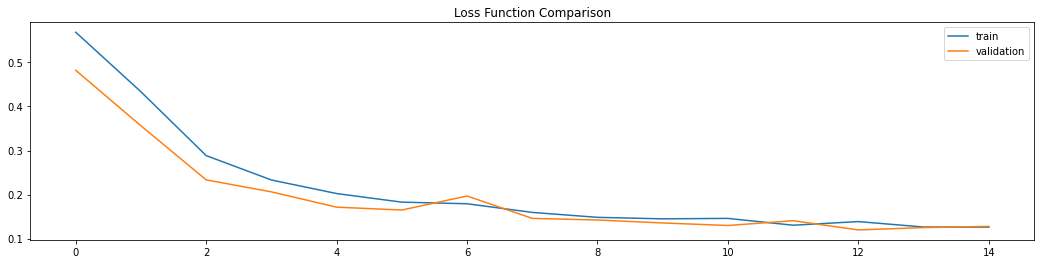

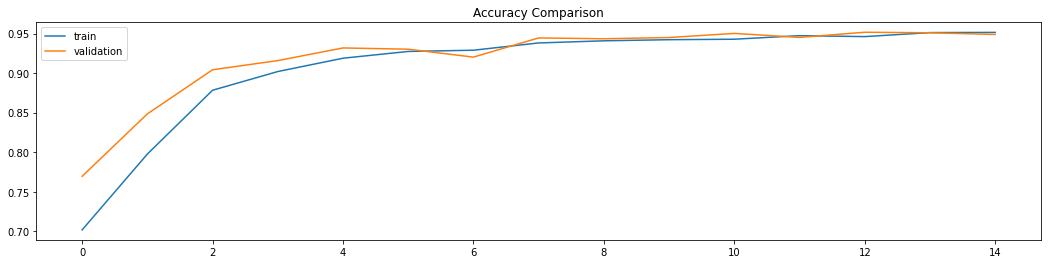

Correct: 9615  Total:  10001
Accuracy:  0.9614038596140386
                                 name  ...  accuracy
0                        simple_model  ...  0.960504
1                simple_model_layer_5  ...  0.950305
2            simple_model_layer_3_inc  ...  0.961704
3  simple_model_layer_3_inc_soft_adam  ...  0.961404

[4 rows x 6 columns]


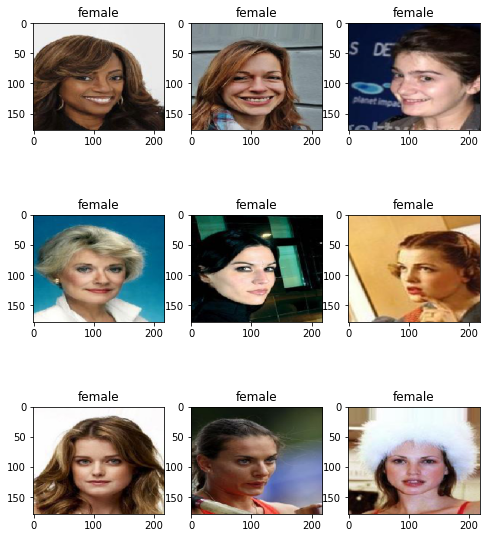

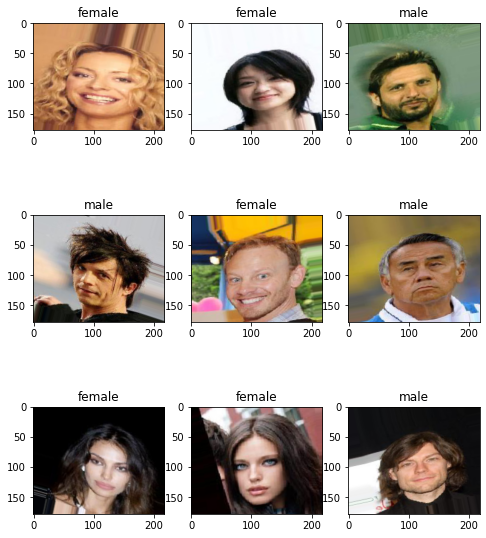

In [ ]:
df_res = train_test_model(model, 'simple_model_layer_3_inc_soft_adam')

So the test accuracy is close to the prevous result = 0.961404.<br>
Let's see if the increased number of layers with the same activation and optimizer will improve the performance.

Model: "simple_model_layer_5_soft_adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 178, 218, 16)      448       
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 218, 16)      2320      
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 218, 16)      2320      
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 218, 16)      2320      
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 218, 16)      2320      
                                                                 
 conv2d_8 (Conv2D)           (None, 178, 218, 16)      2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None,

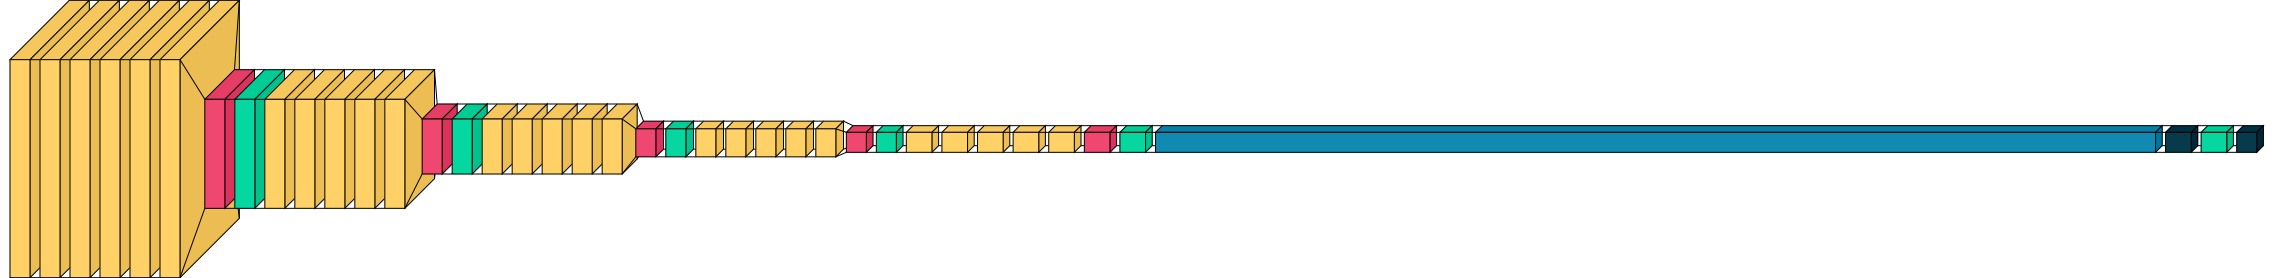

In [ ]:
model = define_model(img_shape, 'simple_model_layer_5_soft_adam', conv_layer_count=5, layers_size=[16, 32, 64, 128, 256], activation='softmax', optimizer=Adam(learning_rate=0.0001))
visualize_model(model, scale=1)

Epoch 1/15
500/500 [==============================] - 190s 377ms/step - loss: 0.6545 - accuracy: 0.6154 - val_loss: 0.5916 - val_accuracy: 0.6880 - lr: 1.0000e-04
Epoch 2/15
500/500 [==============================] - 186s 371ms/step - loss: 0.5418 - accuracy: 0.7343 - val_loss: 0.5233 - val_accuracy: 0.7453 - lr: 1.0000e-04
Epoch 3/15
500/500 [==============================] - 184s 369ms/step - loss: 0.5077 - accuracy: 0.7546 - val_loss: 0.4952 - val_accuracy: 0.7625 - lr: 1.0000e-04
Epoch 4/15
500/500 [==============================] - 184s 368ms/step - loss: 0.4416 - accuracy: 0.7926 - val_loss: 0.4102 - val_accuracy: 0.8197 - lr: 1.0000e-04
Epoch 5/15
500/500 [==============================] - 183s 365ms/step - loss: 0.3602 - accuracy: 0.8431 - val_loss: 0.3186 - val_accuracy: 0.8673 - lr: 1.0000e-04
Epoch 6/15
500/500 [==============================] - 183s 366ms/step - loss: 0.2858 - accuracy: 0.8783 - val_loss: 0.2415 - val_accuracy: 0.8979 - lr: 1.0000e-04
Epoch 7/15
500/500 [==

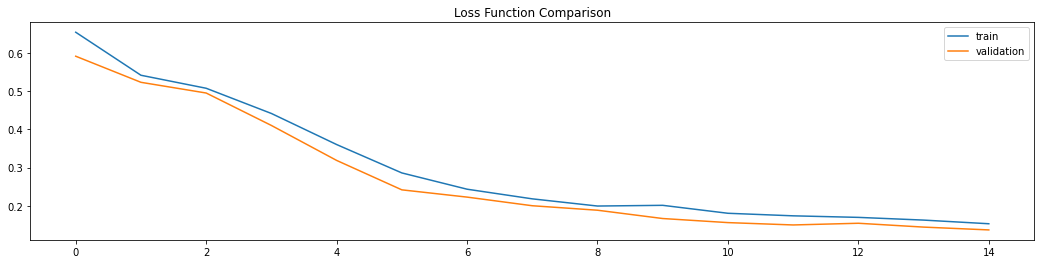

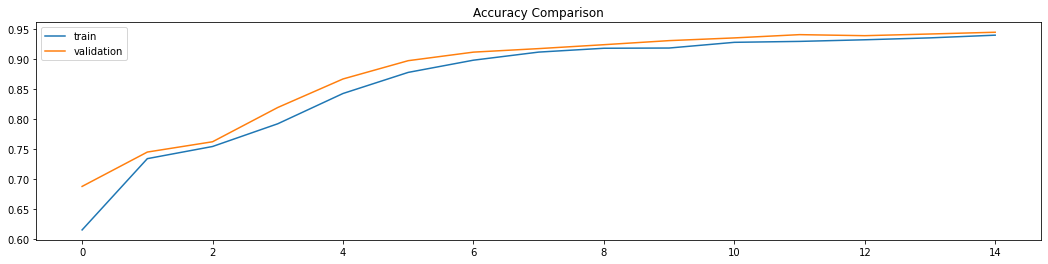

Correct: 9504  Total:  10001
Accuracy:  0.9503049695030497


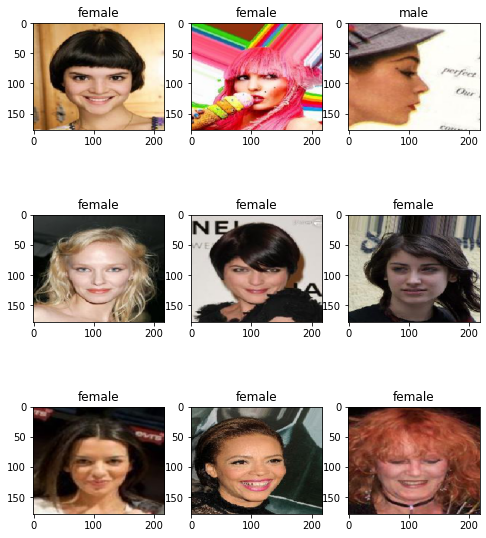

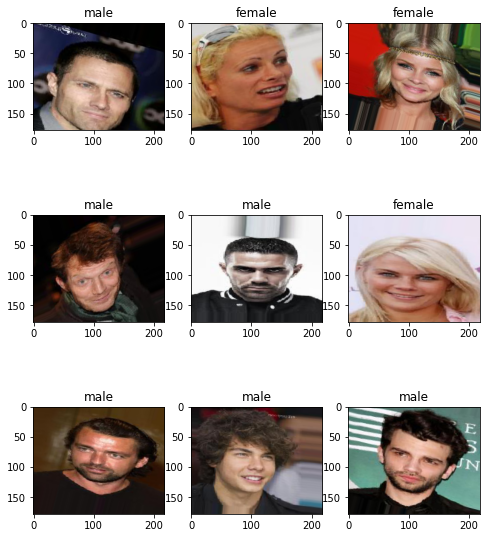

In [ ]:
df_res = train_test_model(model, 'simple_model_layer_5_soft_adam')

The accuracy is equal to 0.9503049695030497. The result is slightly worse than the first model with same weights and less layers (3 blocks, sizes=[32, 64, 128]). And the best results are obtained on models with bigger layers and less blocks (3).

# Predefined models
## VGG16



In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

model = VGG16(include_top=False, input_shape=(img_w, img_h, 3))
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(2, activation='softmax')(class1)
model = Model(inputs=model.inputs, outputs=output)
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 178, 218, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 178, 218, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 178, 218, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 89, 109, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 89, 109, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 89, 109, 128)      147584    
                                                              

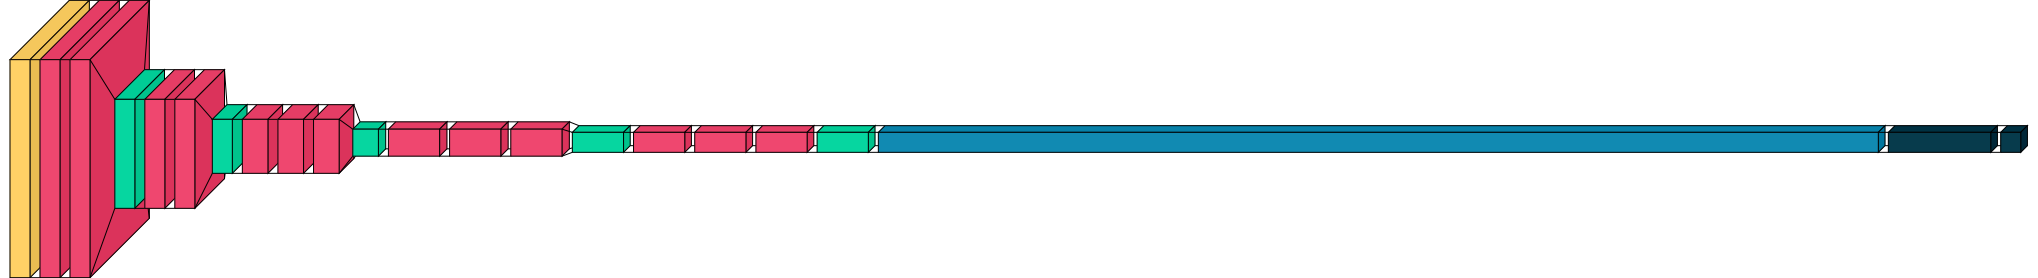

In [ ]:
visualize_model(model, scale=1)

Epoch 1/15
500/500 [==============================] - 194s 379ms/step - loss: 0.3395 - accuracy: 0.8286 - val_loss: 0.1541 - val_accuracy: 0.9397 - lr: 1.0000e-04
Epoch 2/15
500/500 [==============================] - 187s 375ms/step - loss: 0.1423 - accuracy: 0.9446 - val_loss: 0.1592 - val_accuracy: 0.9415 - lr: 1.0000e-04
Epoch 3/15
500/500 [==============================] - 187s 374ms/step - loss: 0.1031 - accuracy: 0.9610 - val_loss: 0.0904 - val_accuracy: 0.9661 - lr: 1.0000e-04
Epoch 4/15
500/500 [==============================] - 187s 374ms/step - loss: 0.0914 - accuracy: 0.9647 - val_loss: 0.1234 - val_accuracy: 0.9484 - lr: 1.0000e-04
Epoch 5/15
500/500 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9672
Epoch 00005: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
500/500 [==============================] - 187s 374ms/step - loss: 0.0877 - accuracy: 0.9672 - val_loss: 0.0872 - val_accuracy: 0.9659 - lr: 1.0000e-04
Epoch 6/15
500/500 [

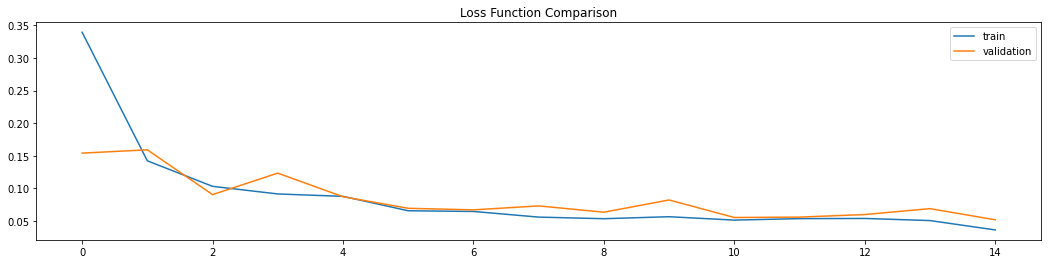

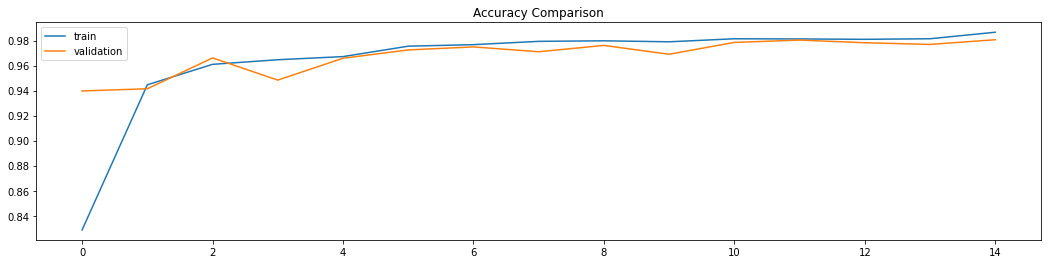

Correct: 9823  Total:  10001
Accuracy:  0.9822017798220178
                                 name  ...  accuracy
0                        simple_model  ...  0.960504
1      simple_model_layer_5_soft_adam  ...  0.950305
2            simple_model_layer_3_inc  ...  0.961704
3  simple_model_layer_3_inc_soft_adam  ...  0.961404
4                               VGG16  ...  0.982202

[5 rows x 6 columns]


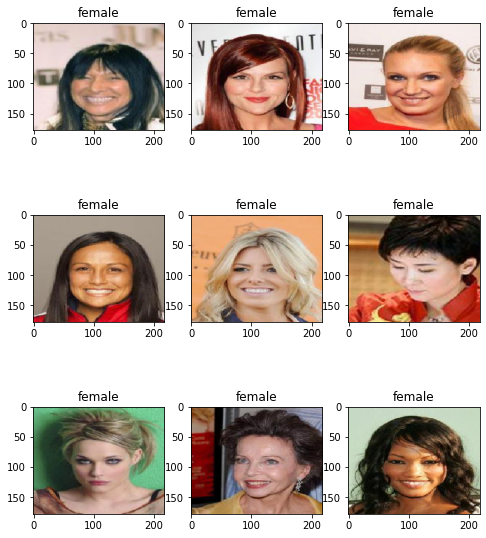

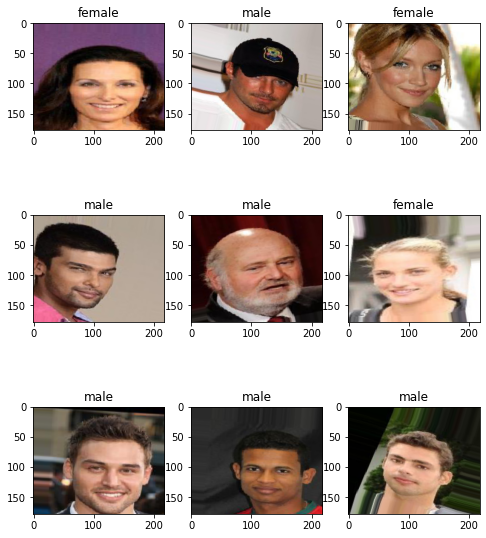

In [ ]:
df_res = train_test_model(model, 'VGG16')

In [ ]:
df_res

name  ...  accuracy
0                        simple_model  ...  0.960504
1      simple_model_layer_5_soft_adam  ...  0.950305
2            simple_model_layer_3_inc  ...  0.961704
3  simple_model_layer_3_inc_soft_adam  ...  0.961404
4                               VGG16  ...  0.982202

[5 rows x 6 columns]

## ResNet50 
Using predefined model ResNet50 trained on Imagenet.

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(img_w, img_h,3), include_top=False, weights="imagenet")
flat = Flatten()(base_model.layers[-1].output)
layer = Dense(1024, activation='relu')(flat)
dropout = Dropout(0.3)(layer)
output = Dense(2, activation='softmax')(dropout)
base_model = Model(inputs=base_model.inputs, outputs=output)
base_model.summary()

base_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

94781440/94765736 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 178, 218, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 184, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 89, 109, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizati

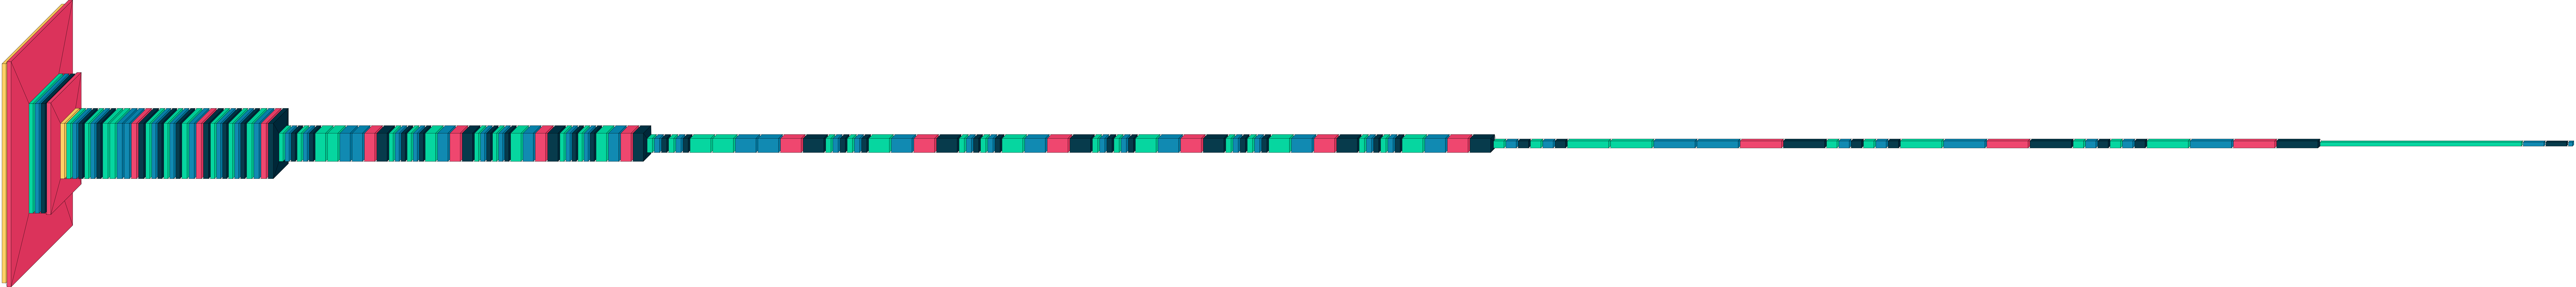

In [ ]:
visualize_model(base_model, scale=5)

Epoch 1/15
500/500 [==============================] - 201s 383ms/step - loss: 1.2318 - accuracy: 0.7859 - val_loss: 0.7050 - val_accuracy: 0.4200 - lr: 0.0010
Epoch 2/15
500/500 [==============================] - 192s 384ms/step - loss: 0.2633 - accuracy: 0.9067 - val_loss: 1.0443 - val_accuracy: 0.7287 - lr: 0.0010
Epoch 3/15
500/500 [==============================] - 191s 382ms/step - loss: 0.1883 - accuracy: 0.9301 - val_loss: 0.2939 - val_accuracy: 0.9203 - lr: 0.0010
Epoch 4/15
500/500 [==============================] - 191s 381ms/step - loss: 0.1689 - accuracy: 0.9405 - val_loss: 0.3732 - val_accuracy: 0.9223 - lr: 0.0010
Epoch 5/15
500/500 [==============================] - 190s 380ms/step - loss: 0.1554 - accuracy: 0.9460 - val_loss: 0.1793 - val_accuracy: 0.9305 - lr: 0.0010
Epoch 6/15
500/500 [==============================] - 190s 379ms/step - loss: 0.1420 - accuracy: 0.9483 - val_loss: 0.1633 - val_accuracy: 0.9436 - lr: 0.0010
Epoch 7/15
500/500 [==========================

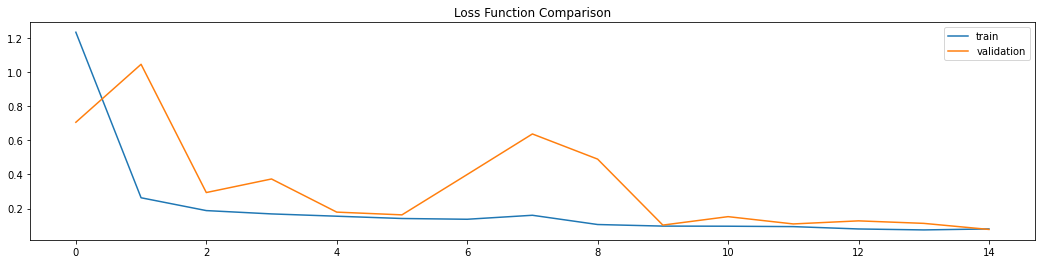

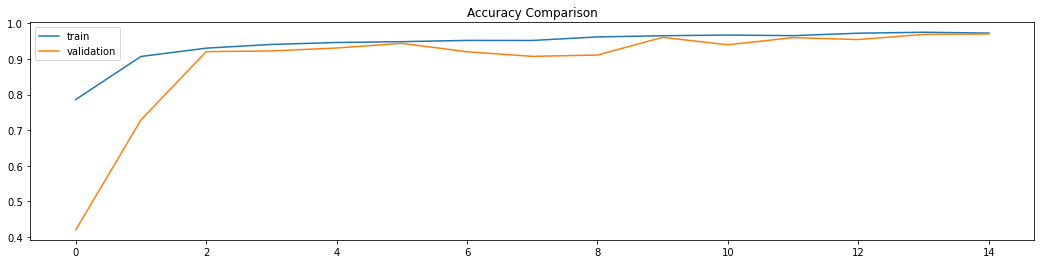

Correct: 9757  Total:  10001
Accuracy:  0.9756024397560243
                                 name  ...  accuracy
0                        simple_model  ...  0.960504
1      simple_model_layer_5_soft_adam  ...  0.950305
2            simple_model_layer_3_inc  ...  0.961704
3  simple_model_layer_3_inc_soft_adam  ...  0.961404
4                               VGG16  ...  0.982202
5                            ResNet50  ...  0.975602

[6 rows x 6 columns]


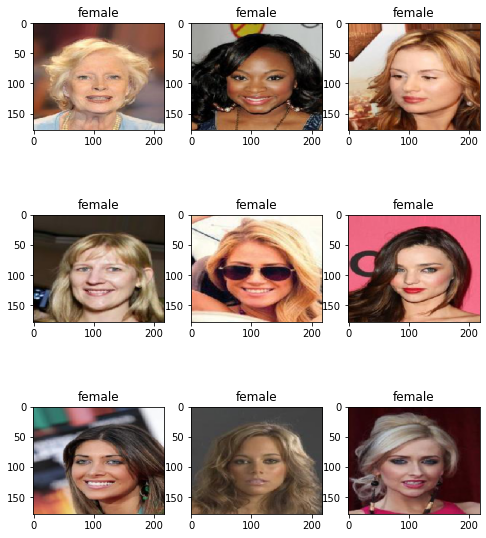

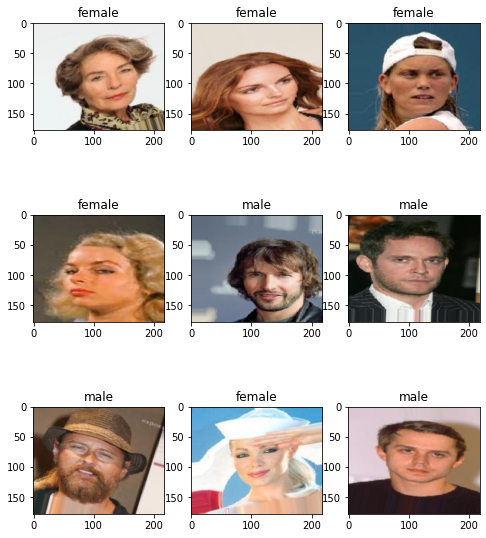

In [ ]:
df_res = train_test_model(base_model, 'ResNet50')

### Saving models' result to a csv file

Let's save all results gotten from train history and test accuracy to a csv file. 

In [ ]:
df_res

name  ...  accuracy
0                        simple_model  ...  0.960504
1      simple_model_layer_5_soft_adam  ...  0.950305
2            simple_model_layer_3_inc  ...  0.961704
3  simple_model_layer_3_inc_soft_adam  ...  0.961404
4                               VGG16  ...  0.982202
5                            ResNet50  ...  0.975602

[6 rows x 6 columns]

In [ ]:
 df_res.to_csv('accuracy_results.csv', index=False)

## Plotting the results 

Let's load the result csv file (so there is no need to rerun/reload models all over again) to a dataframe and visualize the results.

In [31]:
df_res = pd.read_csv('accuracy_results.csv')

The dataframe contains arrays of float values that were parsed as strings, so to get rid of that problem I will convert the columns containing array values to correct type (arrays of floats) 

In [32]:
from ast import literal_eval  
  
df_res.train_loss = df_res.train_loss.apply(lambda x: literal_eval(x))
df_res.train_acc = df_res.train_acc.apply(lambda x: literal_eval(x))
df_res.valid_loss = df_res.valid_loss.apply(lambda x: literal_eval(x))
df_res.valid_acc = df_res.valid_acc.apply(lambda x: literal_eval(x))

In [33]:
df_res

name  ...  accuracy
0                        simple_model  ...  0.960504
1      simple_model_layer_5_soft_adam  ...  0.950305
2            simple_model_layer_3_inc  ...  0.961704
3  simple_model_layer_3_inc_soft_adam  ...  0.961404
4                               VGG16  ...  0.982202
5                            ResNet50  ...  0.975602

[6 rows x 6 columns]

Let's add a column representing epochs, that will be useful for the further visualizations.

In [34]:
epochs_l =  list(range(1, epochs + 1))
df_res['epochs'] = df_res.apply(lambda x: epochs_l, axis=1)

In [35]:
df_res

name  ...                                             epochs
0                        simple_model  ...  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
1      simple_model_layer_5_soft_adam  ...  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
2            simple_model_layer_3_inc  ...  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
3  simple_model_layer_3_inc_soft_adam  ...  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
4                               VGG16  ...  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
5                            ResNet50  ...  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...

[6 rows x 7 columns]

After that step, it's possible to explode the dataframe. That means that now I can split each row's arrays that have the same length (amount of epochs) to rows containing the dedicated array member representing loss and accuracy for the specific epoch keeping the model name and test accuracy columns untouched. 

In [36]:
df_split = df_res.apply(pd.Series.explode)

In [37]:
df_split.head(20)

name train_loss  ...  accuracy epochs
0                    simple_model   0.668819  ...  0.960504      1
0                    simple_model   0.407256  ...  0.960504      2
0                    simple_model   0.336348  ...  0.960504      3
0                    simple_model   0.291585  ...  0.960504      4
0                    simple_model   0.248382  ...  0.960504      5
0                    simple_model   0.237945  ...  0.960504      6
0                    simple_model   0.221612  ...  0.960504      7
0                    simple_model   0.187307  ...  0.960504      8
0                    simple_model   0.178136  ...  0.960504      9
0                    simple_model   0.173068  ...  0.960504     10
0                    simple_model   0.171379  ...  0.960504     11
0                    simple_model   0.165125  ...  0.960504     12
0                    simple_model   0.165374  ...  0.960504     13
0                    simple_model   0.149003  ...  0.960504     14
0                    simple_model   0.150264  ...  0.960504     15
1  simple_model_layer_5_soft_adam   0.654481  ...  0.950305      1
1  simple_model_layer_5_soft_adam   0.541762  ...  0.950305      2
1  simple_model_layer_5_soft_adam   0.507676  ...  0.950305      3
1  simple_model_layer_5_soft_adam   0.441612  ...  0.950305      4
1  simple_model_layer_5_soft_adam   0.360214  ...  0.950305      5

[20 rows x 7 columns]

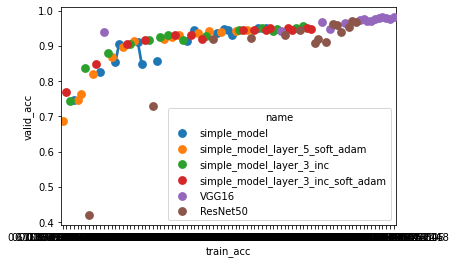

In [ ]:
sns.pointplot(x="train_acc", y="valid_acc", hue='name', data=df_split)

In [38]:
df_split.reset_index(inplace=True)

Let's plot the  loss and accuracy information based on epochs and model name (dashed line for the train values).

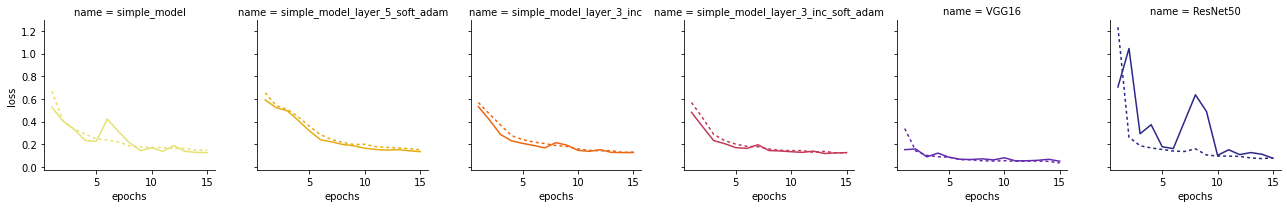

In [ ]:
g = sns.FacetGrid(df_split, col="name", hue="name", palette="CMRmap_r")
g.map(sns.lineplot, "epochs", "train_loss", style=True, dashes=[(2,2)])
g.map(sns.lineplot, "epochs", "valid_loss")
g.set_ylabels('loss')

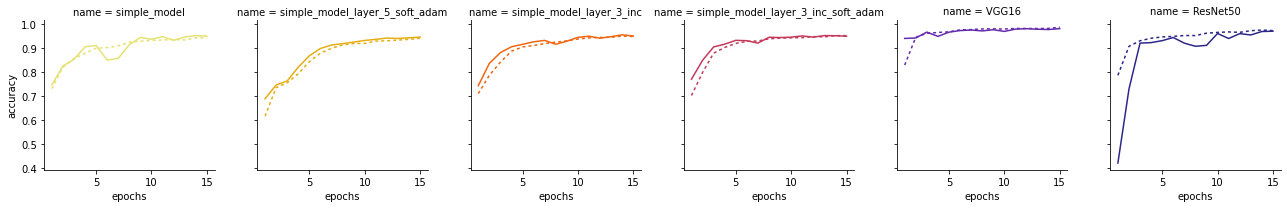

In [ ]:
g = sns.FacetGrid(df_split, col="name", hue="name", palette="CMRmap_r")
g.map(sns.lineplot, "epochs", "train_acc", style=True, dashes=[(2,2)])
g.map(sns.lineplot, "epochs", "valid_acc")
g.set_ylabels('accuracy')

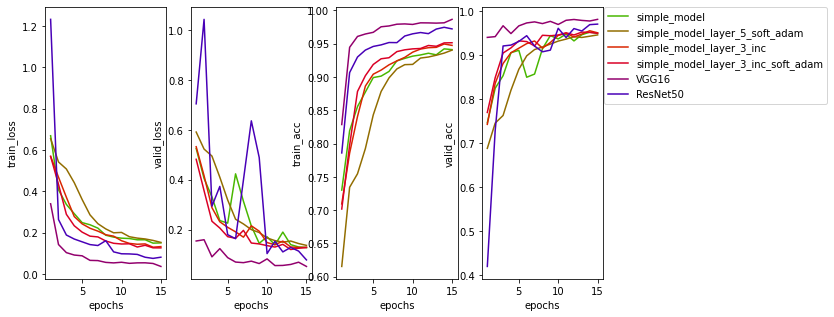

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(10,5))
for i, y in enumerate(['train_loss', 'valid_loss', 'train_acc', 'valid_acc']):
  g = sns.lineplot(data=df_split, y=y, x='epochs', hue='name', palette='brg_r', linewidth=1.5, ax=ax[i])
  if y != 'valid_acc':
    g.get_legend().remove()
  else:
    plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)

[('simple_model', 0.9605039496050396), ('simple_model_layer_5_soft_adam', 0.9503049695030495), ('simple_model_layer_3_inc', 0.9617038296170384), ('simple_model_layer_3_inc_soft_adam', 0.9614038596140386), ('VGG16', 0.9822017798220178), ('ResNet50', 0.9756024397560245)]


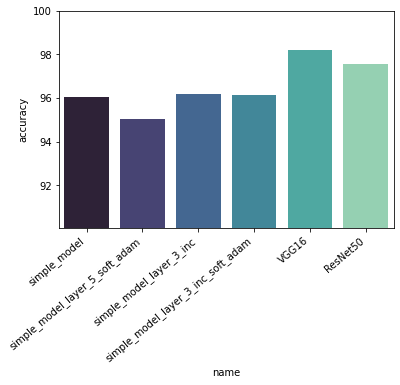

In [68]:
accuracies = df_split['accuracy']*100
g = sns.barplot(x=df_split['name'], y=accuracies, palette='mako')
g.set(ylim=(accuracies.min() - 5, 100.0))
g.set_xticklabels(g.get_xticklabels(), rotation=40, ha="right") 
print(list(zip(df_res.name, df_res.accuracy)))

So the highest accuracy (98%) is reached with predefined model VGG16.